# Import e Configurazione GPU (M1 Max)

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import ast
import torch
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm

# Configurazione Device per M1 Max (MPS)
# Se rileva il chip Apple usa la GPU, altrimenti la CPU
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"🚀 Utilizzo del dispositivo: {device.upper()}")

# Carichiamo il grafo aggregato (quello creato dallo script2.py)
filename = "dataset_snowball_aggregated.gexf"

try:
    G = nx.read_gexf(filename)
    print(f"✅ Grafo caricato! Nodi: {G.number_of_nodes()}, Archi (Relazioni): {G.number_of_edges()}")
except Exception as e:
    print(f"❌ Errore caricamento: {e}")

🚀 Utilizzo del dispositivo: MPS
✅ Grafo caricato! Nodi: 656, Archi (Relazioni): 773


# Caricamento del Modello RoBERTa

In [2]:
# Nome del modello specifico per i social media (Twitter/Bluesky)
MODEL_NAME = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

print(f"📥 Caricamento modello {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Spostiamo il modello sulla GPU (M1 Max)
model.to(device)

print("✅ Modello caricato e pronto su GPU.")

📥 Caricamento modello cardiffnlp/twitter-roberta-base-sentiment-latest...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Modello caricato e pronto su GPU.


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

# Funzione di Analisi (List Processing)

In [3]:
def analyze_comments_list(comments_list):
    """
    Prende una LISTA di commenti (stringhe), analizza ognuno con RoBERTa
    e restituisce il sentiment medio della relazione.
    """
    if not comments_list or len(comments_list) == 0:
        return 0.0

    scores_accumulated = []

    for text in comments_list:
        try:
            # Tokenizzazione (tagliamo a 512 token che è il limite di RoBERTa)
            encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
            
            # Spostiamo i tensori su GPU
            encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
            
            # Inferenza (senza calcolare i gradienti per velocità)
            with torch.no_grad():
                output = model(**encoded_input)
            
            # Calcolo probabilità (Softmax)
            # L'output è [Prob_Negativo, Prob_Neutro, Prob_Positivo]
            scores = softmax(output.logits.detach().cpu().numpy()[0])
            
            # Calcoliamo un punteggio unico da -1 a 1
            # Formula: Positivo - Negativo (Il neutro sposta verso lo 0)
            compound_score = scores[2] - scores[0] 
            scores_accumulated.append(compound_score)
            
        except Exception as e:
            # Se un testo è corrotto o vuoto lo ignoriamo
            continue
            
    # Restituiamo la media dei sentimenti di tutti i commenti in questa relazione
    if not scores_accumulated:
        return 0.0
        
    return float(np.mean(scores_accumulated))

# Esecuzione sul Grafo (Ciclo Principale)

In [4]:
print("🧠 Inizio analisi semantica con RoBERTa...")

# Dizionario per salvare i risultati e aggiornare il grafo
edge_updates = {}
sentiment_values = []

# Cicliamo su tutti gli archi
# G.edges(data=True) ci dà (source, target, attributi)
for u, v, data in tqdm(G.edges(data=True), desc="Analisi Relazioni"):
    
    # 1. Recuperiamo la lista dei commenti
    # Nel GEXF è salvata come stringa "['a', 'b']", dobbiamo convertirla
    comments_str = data.get('comments_list', "[]")
    
    try:
        # ast.literal_eval trasforma la stringa in lista reale in modo sicuro
        real_list = ast.literal_eval(comments_str)
    except:
        real_list = []
        
    # 2. Calcoliamo il sentiment medio della lista
    avg_sentiment = analyze_comments_list(real_list)
    
    # 3. Salviamo il dato
    edge_updates[(u, v)] = avg_sentiment
    sentiment_values.append(avg_sentiment)

# Aggiorniamo gli attributi del grafo
nx.set_edge_attributes(G, edge_updates, 'sentiment_roberta')

print("✅ Analisi completata.")

🧠 Inizio analisi semantica con RoBERTa...


Analisi Relazioni:   0%|          | 0/773 [00:00<?, ?it/s]

✅ Analisi completata.


# Visualizzazione Distribuzione

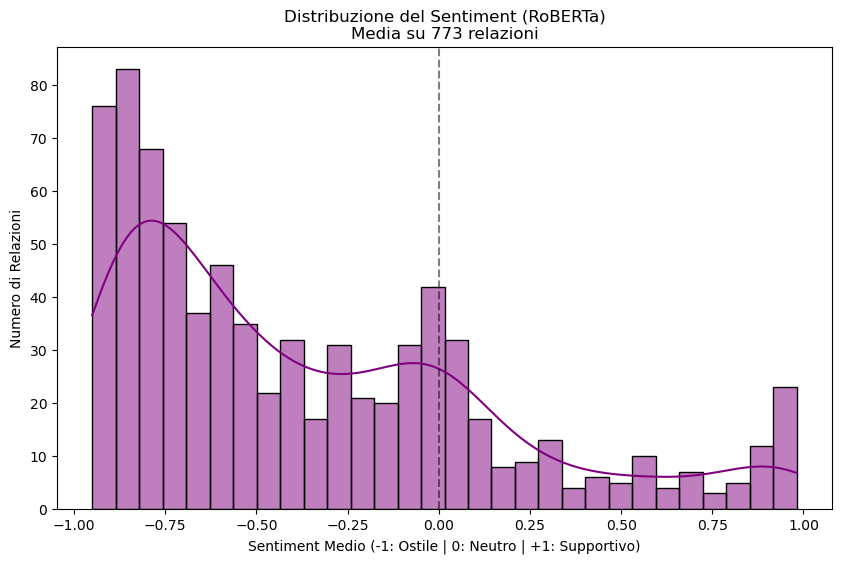

Sentiment Medio Totale: -0.3662
Relazioni Molto Negative (<-0.5): 398
Relazioni Molto Positive (>0.5): 65


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(sentiment_values, bins=30, kde=True, color='purple')
plt.title(f"Distribuzione del Sentiment (RoBERTa)\nMedia su {len(sentiment_values)} relazioni")
plt.xlabel("Sentiment Medio (-1: Ostile | 0: Neutro | +1: Supportivo)")
plt.ylabel("Numero di Relazioni")
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.show()

# Statistiche rapide
print(f"Sentiment Medio Totale: {np.mean(sentiment_values):.4f}")
print(f"Relazioni Molto Negative (<-0.5): {sum(1 for x in sentiment_values if x < -0.5)}")
print(f"Relazioni Molto Positive (>0.5): {sum(1 for x in sentiment_values if x > 0.5)}")

# Calcolo Metriche SNA e Salvataggio Finale

In [6]:
# 1. Calcoliamo le metriche di centralità (visto che ci siamo)
print("🧮 Calcolo metriche di rete...")
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Le aggiungiamo ai nodi
nx.set_node_attributes(G, degree_centrality, 'centrality_degree')
nx.set_node_attributes(G, betweenness_centrality, 'centrality_betweenness')

# 2. Salvataggio
output_file = "dataset_roberta_final.gexf"
nx.write_gexf(G, output_file)

print(f"💾 File salvato: {output_file}")
print("Ora puoi importarlo in Gephi e colorare gli archi con 'sentiment_roberta'!")

🧮 Calcolo metriche di rete...
💾 File salvato: dataset_roberta_final.gexf
Ora puoi importarlo in Gephi e colorare gli archi con 'sentiment_roberta'!
